In [901]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt

from dateutil.parser import parse
from datetime import timedelta
from tqdm import tqdm

### 데이터 불러오기

In [902]:
data = pd.read_csv("data/0mA(29s)~30mA(1s)_(DODI_C).csv") #통합 데이터
data.describe()

Voltage(V)    Current(A)  Resistance(Ohm)      Power(W)
count  4.988486e+06  4.988486e+06     4.988486e+06  4.988486e+06
mean   3.889299e+00  9.340380e-04     1.300571e+04  3.475257e-03
std    3.141821e-02  5.146647e-03     5.870463e+04  1.871865e-02
min    1.680000e-02 -1.500000e-03     0.000000e+00  0.000000e+00
25%    3.888700e+00  0.000000e+00     0.000000e+00  0.000000e+00
50%    3.894900e+00  0.000000e+00     0.000000e+00  0.000000e+00
75%    3.899500e+00  0.000000e+00     1.219480e+02  0.000000e+00
max    3.907000e+00  1.399000e+00     6.489843e+05  1.340000e-01

### 데이터 자르기 (time, volt, current)

In [903]:
data = data.iloc[:, :3] #.values

### 시간을 timedelt로 변경하기 위함

In [904]:
date_=[] #replace korean to english

for i in data['Time'].values:
    i = i.replace("오전", "AM")
    i = i.replace("오후", "PM")
    date_.append(i)

In [905]:
date__=[] #split blank

for i in date_:
    date__.append(i.split(" "))

In [906]:
date___=[] #switch index

for i in date__: #위치 변경
    tmp = i[1] 
    i[1] = i[2]
    i[2] = tmp
    date___.append(i)

In [907]:
parsing_date=[]

for i in tqdm(date___):
    #print('parsing: ', i, "=", (" ").join(i))
    dt = parse((" ").join(i)) #list to string
    #print(dt)
    #print()
    parsing_date.append(dt)

100%|█████████████████████████████████████████████████████████████████████| 4988486/4988486 [07:57<00:00, 10437.50it/s]


### 기준 전압 인덱스 구하기

#### 통신 전류가 시작하는 곳의 직전 인덱스를 기준 전압으로 하였으나 기준이 애매하여 기준을 변경

#### 전압이 낮아지는 곳이 통신이 시작하는 부분

#### 통신 전류가 시작하는 곳의 전압값과 이전 인덱스의 전압값을 비교하여 이전 인덱스의 전압값이 더 크다면 기준 전압으로 하고 그렇지 않다면 기준 전압으로 하지 않는다
1. $> 0.020$ 을 통신 전류로 하여 임시 기준 전압 인덱스를 찾는다
2. 임시 기준 전압값(t)과 그 이전 전압값(t-1)을 비교한다.
3. 이전 전압값(t-1)이 임시 기준 전압값(t)보다 크다면 그 값이 기준 전압값!
4. 같다면 임시 기준 전압값(t)과 전전 전압값(t-2)를 비교
5. 반복


In [908]:
comm_A = np.where(data['Current(A)'] > 0.020) #통신 전류

In [909]:
comm_V_ = np.where(data['Voltage(V)'] < 2.000) #2v가 넘는 곳의 인덱스

In [910]:
comm_V = np.array(comm_V_).reshape(len(comm_V_[0]))

#### 전압이 2v이상인 통신 전류 데이터 인덱스

In [911]:
comm_ = comm_A

for i in comm_V:
    comm_ = np.delete(comm_, np.where(comm_ == i))

#### 전압이 2v이하이면서 통신 전류가 흐르는 데이터가 없는 경우

In [69]:
comm_ = np.array(comm_A[0]) #comm_A[0]의 type이 tuple이기 때문에

In [70]:
comm_

array([      3,       4,       5, ..., 4988382, 4988383, 4988384],
      dtype=int64)

#### 통신 전류 시작 인덱스 하나만

In [912]:
comm = np.array([comm_[0]])

for idx in range(int(len(comm_)-1)):
    if comm_[idx]+1 != comm_[idx+1]:
        comm = np.append(comm, np.array(comm_[idx+1]))

In [913]:
comm

array([    132,     268,     401, ..., 4988164, 4988274, 4988381],
      dtype=int64)

#### 임시 기준 전압(t)은 통신 시작 전류 인덱스 바로 전

In [914]:
t_crit = comm - 1

In [419]:
t_crit.shape

(59559,)

#### 전압이 떨어지기 전의 전압값의 인덱스를 찾아야 함
    - 여기서 인덱스를 잘 골라내야 함!!
    - 전압이 감소하면서 전류가 증가하는 부분이 통신 구간의 시작이다
    - 기존  > 0.020으로 한 경우에는 한 번의 통신에 인덱스가 더 추가된 부분이 있을 수 있음
        - 한 번 더 처리를 한 후에 같은 값(인덱스)가 있으면 제거 (중복 제거)
$ \therefore\; > 0.020 $ 인 부분이면서 전압이 (-), 전류가 (+)인 부분이 최종 통신 시작 인덱스!!

In [1036]:
ref = np.array([], dtype=int)

for t in tqdm(t_crit):
    tmp = t  #tmp는 >0.020 이전의 전압 인덱스
    
    for i in range(1, 5): #4번 loop
        #전압(+): t < t-1
        if (data['Voltage(V)'][tmp] < data['Voltage(V)'][t-i]):
            #t-1 > t-2 => 인덱스 변경: t-i
            if data['Voltage(V)'][t-i] >= data['Voltage(V)'][t-i-1]: #이전 이전의 전압이 더 작으면
                tmp = t-i
                break
            else:
                tmp = t- i
        #전압 (-), 전류 (+) => 인덱스 변경: t-i
        elif (data['Voltage(V)'][tmp] > data['Voltage(V)'][t-i]) and (data['Current(A)'][tmp] < data['Current(A)'][t-i]) and (data['Current(A)'][tmp] != 0.0000) and (data['Current(A)'][t-i] > 0.020):
            tmp = t-i
        #전압(-) => 인덱스 유지
        elif data['Voltage(V)'][tmp] > data['Voltage(V)'][t-i]:
            break
        #전압이 같음: t == t-1
        elif data['Voltage(V)'][tmp] == data['Voltage(V)'][t-i]:
            #t-1 < t-2 => 인덱스 변경: t-i-1
            if data['Voltage(V)'][t-i] < data['Voltage(V)'][t-i-1]:
                tmp = t-i-1
                break
            
    ref = np.append(ref, tmp)
            
ref = np.unique(ref) #중복 값 제거

100%|██████████████████████████████████████████████████████████████████████████| 59559/59559 [00:12<00:00, 4659.71it/s]


In [1037]:
ref.shape

(59557,)

In [1038]:
ref

array([    131,     267,     400, ..., 4988162, 4988273, 4988378],
      dtype=int64)

### 전압 회복 시간, 회복률, 전압을 확인하기 위함
- recovery_time [[통신 전, crit_time]]
- recovery_rate [[통신 중(최대), crit_rate]]
- recovery_volt [[통신 전, 통신 중(최소), crit_volt]]
- crit = 기준 전압 회복률
- 회복률이 crit 이하가 되거나 0이 아니면 다음 통신 데이터로
    - 기준 전압과 통신 전압이 같은 부분이 있어 이상한 데이터가 그려짐 (회복률이 0이 아니면)
- np.delete()하는 이유는 처음에 np.zeros(())로 만들었기 때문에 제일 처음에 0 값이 들어가 있음
    - np.empty(())를 사용하면 쓰레기 값이 들어가 있음 (어차피 같음)

In [1039]:
recovery_time=np.zeros((1,2)) #시간은 통신 전, 회복(crit) 시간
recovery_rate=np.zeros((1,2), dtype=int) #통신(최대), crit(0.5 or smaller)
recovery_volt=np.zeros((1,3), dtype=int) #통신전, 통신(최소), 회복
# index = np.zeros((1,3), dtype=int)

crit = 0.50

for _, i in enumerate(tqdm(ref)): #기준 전압
    r = np.array([]) #max을 구하기 위해서 rate값을 넣을 배열을 생성
    v = np.array([]) #min을 구하기 위해서 volt값을 넣을 배열을 생성
    
    for j in range(1, int(len(data['Voltage(V)']))):
        rate = (data['Voltage(V)'][i] - data['Voltage(V)'][i+j]) * 100 #(기준전압 - 현재전압)*100
        r = np.append(r, np.array([rate])) #배열에 위에서 구한 전압 변화율 추가
        v = np.append(v, np.array([data['Voltage(V)'][i+j]])) #배열에 현재 전압값 추가

        #회복 전압이면 반복을 멈추고 각 배열에 요소 추가
        # 1. 현재 전압 < 다음 전압 && 2. 다음 전류가 0.020보다 작을 때 && 3. 현재 전압 변화율 <= 기준 전압 변화율 && 4. 전압 변화율 != 0
        if (data['Voltage(V)'][i+j] < data['Voltage(V)'][i+j+1]) and (data['Current(A)'][i+j+1] < 0.020) and (rate <= crit) and (rate != 0.0000):
            #전압 변화율 추가(최대 전압 변화율(최저 전압), 현재 전압 변화율)
            recovery_rate = np.append(recovery_rate, np.array([np.max(r), rate]).reshape(1,2), axis=0)
            #전압 회복 시간(기준 전압 시간, 회복 전압 시간)
            recovery_time = np.append(recovery_time, np.array([parsing_date[i], parsing_date[i+j]]).reshape(1,2), axis=0)
            #전압(기준 전압, 최저 전압, 회복 전압)
            recovery_volt = np.append(recovery_volt, np.array([data['Voltage(V)'][i], np.min(v), data['Voltage(V)'][i+j]]).reshape(1,3), axis=0)

            break
            
recovery_rate = np.delete(recovery_rate, 0, 0)
recovery_time = np.delete(recovery_time, 0, 0)
recovery_volt = np.delete(recovery_volt, 0, 0)

100%|███████████████████████████████████████████████████████████████████████████| 59557/59557 [02:31<00:00, 393.79it/s]


### 그래프를 그려 변화 확인

#### 통신시에 전압을 얼마나 사용하는지 볼 수 있음

In [1063]:
recovery_time[51748]

array([datetime.datetime(2021, 10, 12, 16, 7, 25),
       datetime.datetime(2021, 10, 12, 16, 7, 28)], dtype=object)

In [1064]:
recovery_volt[51748]

array([3.8877, 3.8746, 3.8829])

In [886]:
(recovery_volt[26080][0] - recovery_volt[26080][2]) * 100

0.45999999999999375

In [1062]:
np.argmin(np.max(recovery_rate[51700:52000], axis=1))

48

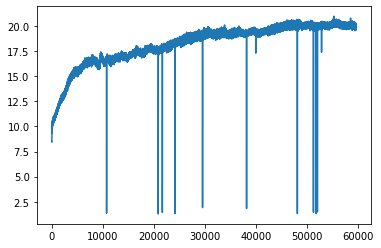

In [1041]:
plt.plot(np.max(recovery_rate[:], axis=1))

#### 시간은 timedelt형으로 되어 있기 때문에 회복 시간을 보기 위해서는 처리가 필요

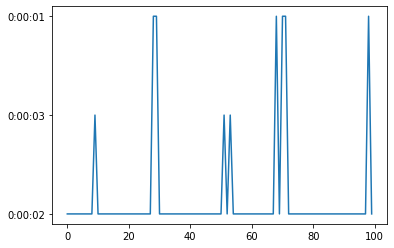

In [1077]:
re_time = []

for i in recovery_time:
    re_time.append(str(i[1] - i[0]))
    
plt.plot(re_time[100:200])

#### 통신 전, 통신 중, 회복 전압 그래프

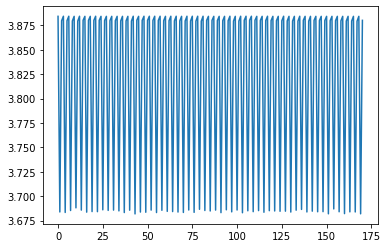

In [1074]:
plt.plot(recovery_volt[59500:].flatten())